# Genome-Wide Association Exercise Association Analysis Controlling for Population Substructure

## 1. Population Stratification and Association Testing

The dataset from part I of this exercise which you performed data quality control (QC) on was obtained from HapMap Phase III data. It contains CEU founders (Caucasians from Utah), MEX founders (Mexicans from Los Angeles) and TSI (Tuscans from Italy). The CEU pedigree identifiers begin with only numbers e.g., 1347, the MEX pedigree identifies all start with M e.g., M017 and the TSI pedigree identifiers all start with NA e.g., NA0217. Before we start testing for association, we want to know if there are outliers. Even after removing the outliers when association analysis is performed population substructure and admixture may need to be controlled. If not, we risk observing an association, which is due to a difference in genotype frequencies in cases and controls, because of population substructure/admixture and not because of linkage disequilibrium (LD) between tagSNP(s) and the functional variant(s). We are going to use multidimensional scaling (MDS) and principal components analysis (PCA) within the PLINK software to generate 10 components. 

**Disclaimer: You usually should not analyze data from European-Americans, Mexican- Americans and Italians together even if you control for population stratification. They can be analyzed separately, and the data combined using meta-analysis.**

**Note:** For a GWAS study instead of this toy study, you will have a denser set of markers of which some will be in LD. You should first prune your SNPs to obtain a subset in linkage equilibrium/weak LD (R2<0.5) prior to performing MDS or PCA analysis on the data. Although for association analysis is performed on the entire data set will be analyzed only this a subset of SNPs which are not in LD will be used to construct PCA and MDS components. For more information on how to do this in PLINK see https://www.cog-genomics.org/plink/1.9/ld.

In [1]:
cd ./Plink_substructure

In [2]:
plink --file GWAS_clean4 --genome --cluster --mds-plot 10

PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --cluster
  --file GWAS_clean4
  --genome
  --mds-plot 10

7960 MB RAM detected; reserving 3980 MB for main workspace.
.ped scan complete (for binary autoconversion).51515161617171818181919202020212122222223232424242525262627272728282929293030313131323233333434343535363636373738383839394040404141424243434344444545454646474747484849494950505151525252535354545455555656565757585859595960606161616262636363646465656566666767686868696970707071717272727373747474757576767777777878797979808081818182828383848484858586868687878888888989909090919192929393939494959595969697979798989999100%
Performing single-pass .bed write (6362 variants, 244 people).
--file: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam546474849505152535455565758596061626364656667686970717273747576777879808182838485

This command outputs the file `plink.mds` that contains the subject IDs and values for the 10 components we just generated. There is another file in your folder called `mds_components.txt`. This file is identical to your `plink.mds` file with the exception that a group column which codes CEU individuals as 1, MEX individuals as 2 and TSI individuals as 3. This is done so when we plot the MDS components in R you can see which group the points belong to and judge how well does the data cluster, e.g., are there outliers. The following commands will generate a jpeg image file containing the mds `plot (filename=mds.jpeg)` in your current working directory. Open R and use the following command:

In [3]:
setwd('./Plink_substructure/')

null device 
          1

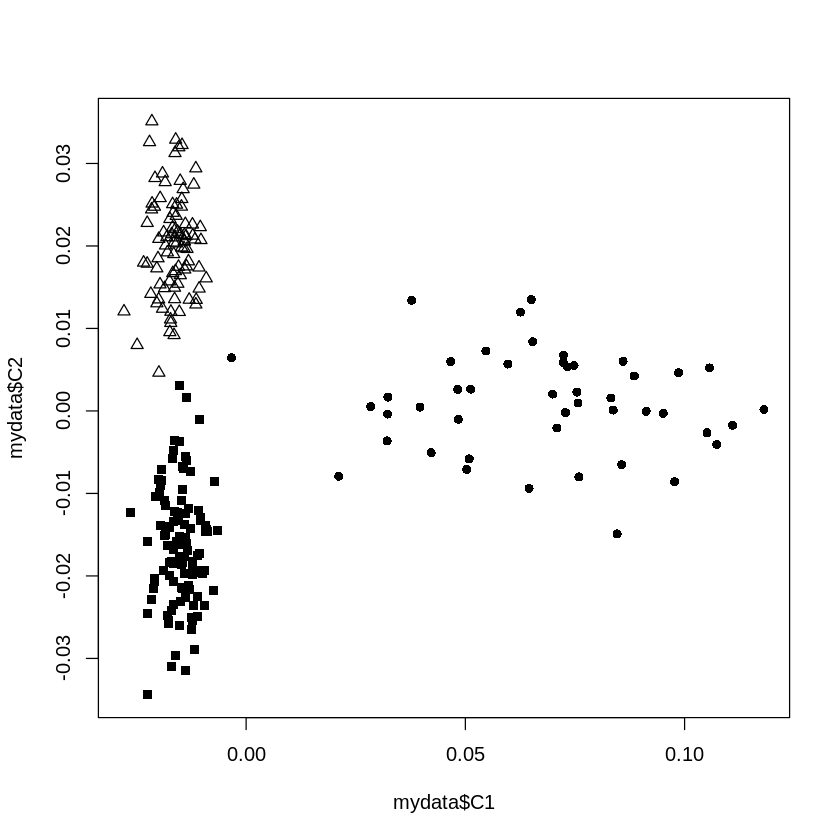

In [6]:
mydata = read.table("mds_components.txt", header=T)
mydata$pch[mydata$Group==1 ] <-15 
mydata$pch[mydata$Group==2 ] <-16 
mydata$pch[mydata$Group==3 ] <-2
#jpeg("mds.jpeg", height=500, width=500) 
plot(mydata$C1, mydata$C2 ,pch=mydata$pch) 
dev.off()

Visualizing population structure using MDS is useful for identifying subpopulations, population stratification and systematic genotyping or sequencing errors, and can also be used to detect individual outliers that may need to be removed, e.g. European-Americans included in a study of African-Americans. MDS coordinates help with visualizing genetic distances and population substructure. PLINK also offers another dimension reduction, --pca, for PCA, the PC components which can also be used for visualizing data to detect outliers in the same manner which was performed using MDS. Additionally, covariates either from either MDS or PCA can be used in a regression model to aid in correcting for population substructure and admixture.

We will now continue performing the analysis using PLINK but will use PCA instead of MDS. We will generate PCs and determine how many PC covariates should be included in the regression model. When SNPs are tested for an association with a trait analysis can be performed, first by including no PC components, then one PC component and then two PC components and so on. Please note that as each PC component is added all the SNPs are analyzed, e.g. a complete GWAS is performed. Examining λ can aid in determining how many PC components should be included in the analysis. If there is no population stratification or other biases, then λ should equal 1 or ~1. We will use λ to determine how many PC components from our analysis will be added to the logistic regression model. First, estimate λ without adjusting for any PC components:

In [8]:
plink --file GWAS_clean4 --pheno pheno.txt --pheno-name Aff --logistic --adjust --out unadj

PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to unadj.log.
Options in effect:
  --adjust
  --file GWAS_clean4
  --logistic
  --out unadj
  --pheno pheno.txt
  --pheno-name Aff

7960 MB RAM detected; reserving 3980 MB for main workspace.
.ped scan complete (for binary autoconversion).51515161617171818181919202020212122222223232424242525262627272728282929293030313131323233333434343535363636373738383839394040404141424243434344444545454646474747484849494950505151525252535354545455555656565757585859595960606161616262636363646465656566666767686868696970707071717272727373747474757576767777777878797979808081818182828383848484858586868687878888888989909090919192929393939494959595969697979798989999100%
Performing single-pass .bed write (6362 variants, 244 people).
--file: unadj-temporary.bed + unadj-temporary.bim + unadj-temporary.fam5464748495051525354555657585960616263646566

Generated the first 10 PCA values:

In [9]:
plink --file GWAS_clean4 --genome --cluster --pca 10 header

PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --cluster
  --file GWAS_clean4
  --genome
  --pca 10 header

7960 MB RAM detected; reserving 3980 MB for main workspace.
.ped scan complete (for binary autoconversion).51515161617171818181919202020212122222223232424242525262627272728282929293030313131323233333434343535363636373738383839394040404141424243434344444545454646474747484849494950505151525252535354545455555656565757585859595960606161616262636363646465656566666767686868696970707071717272727373747474757576767777777878797979808081818182828383848484858586868687878888888989909090919192929393939494959595969697979798989999100%
Performing single-pass .bed write (6362 variants, 244 people).
--file: plink-temporary.bed + plink-temporary.bim + plink-temporary.fam5464748495051525354555657585960616263646566676869707172737475767778798081828384

Eigenvectors are written to plink.eigenvec, and top eigenvalues are written to plink.eigenval. The 'header' modifier adds a header line to the .eigenvec file(s).
And then find out what λ is when we adjust for the first component:

In [10]:
plink --file GWAS_clean4 --pheno pheno.txt --pheno-name Aff --covar plink.eigenvec --covar-name PC1 --logistic --adjust --out PC1

PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to PC1.log.
Options in effect:
  --adjust
  --covar plink.eigenvec
  --covar-name PC1
  --file GWAS_clean4
  --logistic
  --out PC1
  --pheno pheno.txt
  --pheno-name Aff

7960 MB RAM detected; reserving 3980 MB for main workspace.
.ped scan complete (for binary autoconversion).51515161617171818181919202020212122222223232424242525262627272728282929293030313131323233333434343535363636373738383839394040404141424243434344444545454646474747484849494950505151525252535354545455555656565757585859595960606161616262636363646465656566666767686868696970707071717272727373747474757576767777777878797979808081818182828383848484858586868687878888888989909090919192929393939494959595969697979798989999100%
Performing single-pass .bed write (6362 variants, 244 people).
--file: PC1-temporary.bed + PC1-temporary.bim + PC1-temporary.fam written.

And the first and second components:

In [11]:
plink --file GWAS_clean4 --pheno pheno.txt --pheno-name Aff --covar plink.eigenvec --covar-name PC1-PC2 --logistic --adjust --out PC1-PC2

PLINK v1.90b6.18 64-bit (16 Jun 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to PC1-PC2.log.
Options in effect:
  --adjust
  --covar plink.eigenvec
  --covar-name PC1-PC2
  --file GWAS_clean4
  --logistic
  --out PC1-PC2
  --pheno pheno.txt
  --pheno-name Aff

7960 MB RAM detected; reserving 3980 MB for main workspace.
.ped scan complete (for binary autoconversion).51515161617171818181919202020212122222223232424242525262627272728282929293030313131323233333434343535363636373738383839394040404141424243434344444545454646474747484849494950505151525252535354545455555656565757585859595960606161616262636363646465656566666767686868696970707071717272727373747474757576767777777878797979808081818182828383848484858586868687878888888989909090919192929393939494959595969697979798989999100%
Performing single-pass .bed write (6362 variants, 244 people).
--file: PC1-PC2-temporary.bed + PC1-PC2-temporary.bim + PC1-PC

and so forth for all 10 components in the .log file completing the table:

<table style="border-bottom:1px solid; border-right: 1px solid; border-spacing:0px; font-size:10pt; text-align:left;">
    <tr style="text-align:center; vertical-align:bottom;">
        <td width="90" style="border:none; height: 50px; vertical-align:top;">
            <span style="font-size:12pt; font-weight:bold;">
                Table 1<br />
            </span>
        </td>
        <th width="50" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">Un-adjusted</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&nbsp;&nbsp;</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;2</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;3</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;4</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;5</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;6</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;7</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;8</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;9</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;10</th>
    </tr>
    <tr>
        <th style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid; text-align:center;">&lambda;</th>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
        <td style="border-left:1px solid; border-top:1px solid;">&nbsp;</td>
    </tr>
</table>

The number closest to 1.0, with the least number of PC components, would be the best for adjusting without overfitting and introducing unnecessary noise. You can check your table against the one provided in the answers section.

Go to the **`assoc.logistic` file that corresponds to that number of components** and make a note of how you named the `.assoc.logistic` file for it and when you did not adjust for any components. Then go back to the R program to load the results and create a jpeg image file containing QQ plots for the adjusted and unadjusted results (using a modified script from http://www.broad.mit.edu/node/555) as follows:


null device 
          1

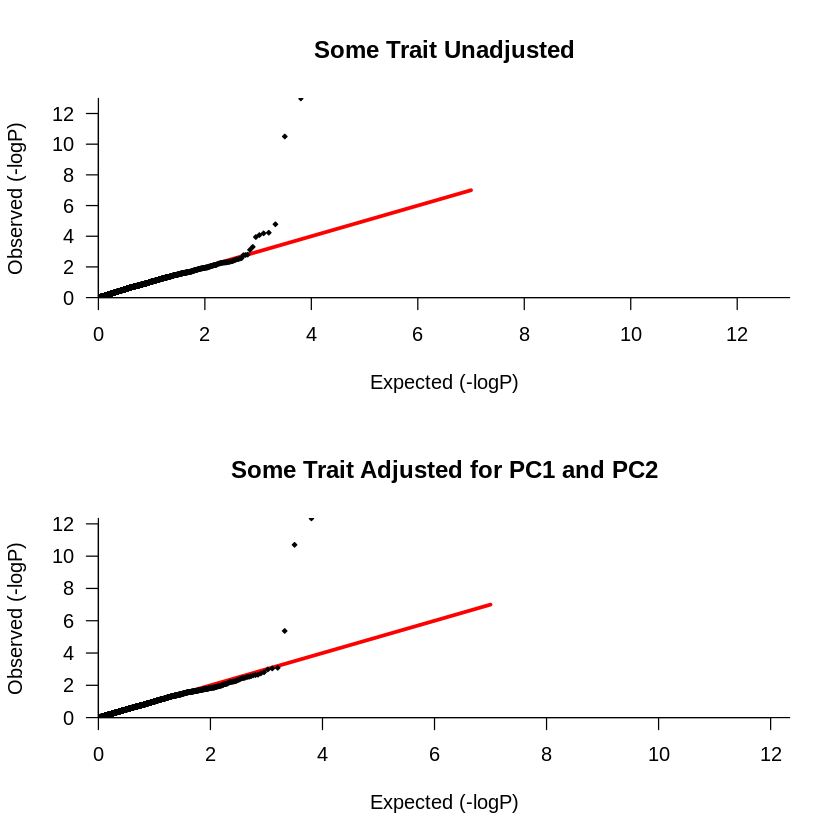

In [15]:
broadqq <-function(pvals, title) {
    observed <- sort(pvals) 
    lobs <- -(log10(observed))
    expected <- c(1:length(observed))
    lexp <- -(log10(expected / (length(expected)+1)))
    plot(c(0,7), c(0,7), col="red", lwd=3, type="l", xlab="Expected (-logP)", ylab="Observed (-logP)",
         xlim=c(0,max(lobs)), ylim=c(0,max(lobs)), las=1, xaxs="i", yaxs="i", bty="l", main = title)
    points(lexp, lobs, pch=23, cex=.4, bg="black") 
}
#jpeg("qqplot_compare.jpeg", height=1000, width=500) 
par(mfrow=c(2,1))
aff_unadj<-read.table("unadj.assoc.logistic", header=TRUE) 
aff_unadj.add.p<-aff_unadj[aff_unadj$TEST==c("ADD"),]$P 
broadqq(aff_unadj.add.p,"Some Trait Unadjusted") 
aff_C1C2<-read.table("PC1-PC2.assoc.logistic", header=TRUE) 
aff_C1C2.add.p<-aff_C1C2[aff_C1C2$TEST==c("ADD"),]$P 
broadqq(aff_C1C2.add.p, "Some Trait Adjusted for PC1 and PC2")
dev.off()

Now look for SNPs with genome-wide significance using the following R connamds:

In [16]:
gws_unadj = aff_unadj[which(aff_unadj$P < 0.0000001),] 
gws_unadj
gws_adjusted = aff_C1C2[which(aff_C1C2$P < 0.0000001),] 
gws_adjusted

CHR SNP        BP        A1 TEST NMISS OR      STAT   P        
1800 4   rs10008252 179853616 G  ADD  244   0.16650 -6.639 3.155e-11
3131 8   rs4571722   60326734 T  ADD  242   0.04126 -7.436 1.037e-13

CHR SNP        BP        A1 TEST NMISS OR      STAT   P        
5398 4   rs10008252 179853616 G  ADD  244   0.13070 -6.707 1.985e-11
9391 8   rs4571722   60326734 T  ADD  242   0.04382 -7.237 4.585e-13

**Note:** These are the uncorrected p-values for multiple testing. The p-values which have been corrected using various multiple testing methods can be found in the .adjusted file.

A common question when you have a finding with genome-wide significance in a GWAS is “Is the SNP in a known gene?” One way to look this information up is annotate variants in batch (please look at the annotating exercise for more information). You can do this using the Ensembl Variant Predictor. Go to the website:

http://grch37.ensembl.org/Homo_sapiens/Tools/VEP (GRCh37 version)

Type the rs number(s) of the SNP(s) with genome-wide significance in “Either paste data”, leave all options default and press run. In a few minutes you can view the results of your query.

## 2. Questions

**Question 1:** Did this study have a finding with genome-wide significance after adjusting for population substructure? Did you notice any difference in the p-values before and after adjustment for substructure? How many PC components should you include in the regression model?

<table style="border-spacing:0px; font-size:10pt; text-align:left;">
    <tr>
        <td colspan="9" style="border-bottom:1px solid; padding:0; text-align:left;">
            <span style="font-family:'Times New Roman',Times,serif; font-size:12pt; font-weight:bold;">
                Table 2. SNPs with genome-wide significance unadjusted for substructure:
            </span>
        </td>
    </tr>
    <tr style="font-weight:bold; text-align:center;">
        <th width="30" style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">CHR</th>
        <th width="70" style="border-bottom: 1px solid; border-right:1px solid;">SNP</th>
        <th width="60" style="border-bottom: 1px solid; border-right:1px solid;">BP</th>
        <th width="25" style="border-bottom: 1px solid; border-right:1px solid;">A1</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">TEST</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">NMISS</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">OR</th>
        <th width="50" style="border-bottom: 1px solid; border-right:1px solid;">STAT</th>
        <th width="55" style="border-bottom: 1px solid; border-right:1px solid;">P</th>
    </tr>
    <tr>
        <td style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
    </tr>
    <tr>
        <td style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
    </tr>
</table>

<table style="border-spacing:0px; font-size:10pt; text-align:left;">
    <tr>
        <td colspan="9" style="border-bottom:1px solid; padding:0; text-align:left;">
            <span style="font-family:'Times New Roman',Times,serif; font-size:12pt; font-weight:bold;">
                Table 3. SNPs with genome-wide significance adjusted for components 1 and 2:
            </span>
        </td>
    </tr>
    <tr style="font-weight:bold; text-align:center;">
        <th width="30" style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">CHR</th>
        <th width="70" style="border-bottom: 1px solid; border-right:1px solid;">SNP</th>
        <th width="60" style="border-bottom: 1px solid; border-right:1px solid;">BP</th>
        <th width="25" style="border-bottom: 1px solid; border-right:1px solid;">A1</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">TEST</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">NMISS</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">OR</th>
        <th width="50" style="border-bottom: 1px solid; border-right:1px solid;">STAT</th>
        <th width="55" style="border-bottom: 1px solid; border-right:1px solid;">P</th>
    </tr>
    <tr>
        <td style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
    </tr>
    <tr>
        <td style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">&nbsp;</td>
    </tr>
</table>

**Question 2:** Why would you not want to include in your analysis individuals from different ethnic backgrounds even if you control for population substructure?

**Question 3:** Are any SNPs with genome-wide significance in known genes?

## 3. Answers and Output

<table style="border-bottom:1px solid; border-right: 1px solid; border-spacing:0px; font-size:10pt; text-align:left;">
    <tr style="text-align:center; vertical-align:bottom;">
        <td width="90" style="border:none; height: 50px; vertical-align:top;">
            <span style="font-size:12pt; font-weight:bold;">
                Table 1<br />
            </span>
        </td>
        <th width="50" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">Un-adjusted</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&nbsp;&nbsp;</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;2</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;3</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;4</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;5</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;6</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;7</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;8</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;9</th>
        <th width="25" style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid;">PC 1&#8209;10</th>
    </tr>
    <tr>
        <th style="background-color:rgba(196,196,196,0.5); border-left:1px solid; border-top:1px solid; text-align:center;">&lambda;</th>
        <td style="border-left:1px solid; border-top:1px solid;">1.2.1</td>
        <td style="border-left:1px solid; border-top:1px solid;">1.085</td>
        <td style="border-left:1px solid; border-top:1px solid;">1.026</td>
        <td style="border-left:1px solid; border-top:1px solid;">1.033</td>
        <td style="border-left:1px solid; border-top:1px solid;">1.040</td>
        <td style="border-left:1px solid; border-top:1px solid;">1.050</td>
        <td style="border-left:1px solid; border-top:1px solid;">1.043</td>
        <td style="border-left:1px solid; border-top:1px solid;">1.021</td>
        <td style="border-left:1px solid; border-top:1px solid;">1.036</td>
        <td style="border-left:1px solid; border-top:1px solid;">1.043</td>
        <td style="border-left:1px solid; border-top:1px solid;">1.051</td>
    </tr>
</table>

**Answer 1:** Yes, see tables below. It is best to include to two PC components in the analysis, however the lambda is still inflated. Since we are analyzing three unique populations inclusion of PCs did not adequately control for substructure. If you compare the QQ plots below you can see that for this dataset the most significant SNPs were changed minimally when we adjusted for substructure but some of the moderately significant SNPs became less significant after adjustment. However, in some situations the p-values can become smaller.

<table style="border-spacing:0px; font-size:10pt; text-align:left;">
    <tr>
        <td colspan="9" style="border-bottom:1px solid; padding:0; text-align:left;">
            <span style="font-family:'Times New Roman',Times,serif; font-size:12pt; font-weight:bold;">
                Table 2. SNPs with genome-wide significance unadjusted for substructure:
            </span>
        </td>
    </tr>
    <tr style="font-weight:bold; text-align:center;">
        <th width="30" style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">CHR</th>
        <th width="70" style="border-bottom: 1px solid; border-right:1px solid;">SNP</th>
        <th width="60" style="border-bottom: 1px solid; border-right:1px solid;">BP</th>
        <th width="25" style="border-bottom: 1px solid; border-right:1px solid;">A1</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">TEST</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">NMISS</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">OR</th>
        <th width="50" style="border-bottom: 1px solid; border-right:1px solid;">STAT</th>
        <th width="55" style="border-bottom: 1px solid; border-right:1px solid;">P</th>
    </tr>
    <tr>
        <td style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">8</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">rs4571722</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">60326734</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">T</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">ADD</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">242</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">0.04126</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">-7.436</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">1.04E-13</td>
    </tr>
    <tr>
        <td style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">4</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">rs10008252</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">179853616</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">G</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">ADD</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">244</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">0.1665</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">-6.639</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">316E-11</td>
    </tr>
</table>

<table style="border-spacing:0px; font-size:10pt; text-align:left;">
    <tr>
        <td colspan="9" style="border-bottom:1px solid; padding:0; text-align:left;">
            <span style="font-family:'Times New Roman',Times,serif; font-size:12pt; font-weight:bold;">
                Table 3. SNPs with genome-wide significance adjusted for components 1 and 2:
            </span>
        </td>
    </tr>
    <tr style="font-weight:bold; text-align:center;">
        <th width="30" style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">CHR</th>
        <th width="70" style="border-bottom: 1px solid; border-right:1px solid;">SNP</th>
        <th width="60" style="border-bottom: 1px solid; border-right:1px solid;">BP</th>
        <th width="25" style="border-bottom: 1px solid; border-right:1px solid;">A1</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">TEST</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">NMISS</th>
        <th width="45" style="border-bottom: 1px solid; border-right:1px solid;">OR</th>
        <th width="50" style="border-bottom: 1px solid; border-right:1px solid;">STAT</th>
        <th width="55" style="border-bottom: 1px solid; border-right:1px solid;">P</th>
    </tr>
    <tr>
        <td style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">8</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">rs4571722</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">60326734</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">T</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">ADD</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">242</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">0.04382</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">-7.237</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">4.59E-13</td>
    </tr>
    <tr>
        <td style="border-bottom: 1px solid; border-left:1px solid; border-right:1px solid;">4</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">rs10008252</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">179853616</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">G</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">ADD</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">244</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">0.13070</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">-6.707</td>
        <td style="border-bottom: 1px solid; border-right:1px solid;">1.99E-11</td>
    </tr>
</table>

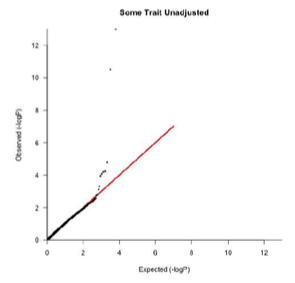
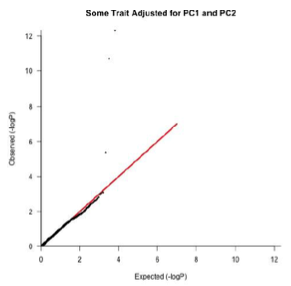

**Answer 2:** Firstly, you may not be able to adequately control for population substructure. Secondly, even if within the different populations the same genes are involved, for common variants LD structure can vary between populations, e.g., the tagSNPs in the different populations can have different allele frequencies, therefore the functional variant will not be tagged equally well in all populations and power can be reduced. It is also possible that different variants are associated, but for common variants, which are very old, usually this is not the cause. If a study involves individuals of different ancestry analysis can be performed separately and the results can be combined via meta-analysis. Studying individuals of different ancestry can be highly beneficial to fine map loci.

**Answer 3:** No, both rs457122 and rs10008252 are intergenic/intronic.